In [ ]:
# names:
# TUYISENGE Emmanuel
# NISINGIZWE NIYIGENA Nicole
# ASHIMWE DENYSE
# IKIREZI UMUNYANA HONORINE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle_dataset'
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
%cd /content/drive/MyDrive/kaggle_dataset

/content/drive/MyDrive/kaggle_dataset


In [ ]:
#!kaggle datasets download -d joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20

In [ ]:
!ls

 app.py		      'cowpox cow.jpg'	 model.pth	  mpox_dataset	 templates
'Copy of mpox.ipynb'   me.jpeg		 mopoxchild.jpg   mpox.ipynb


In [ ]:
import numpy as np

In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:


# Define the device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device (GPU/CPU)
#model = model.to(device)


In [ ]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


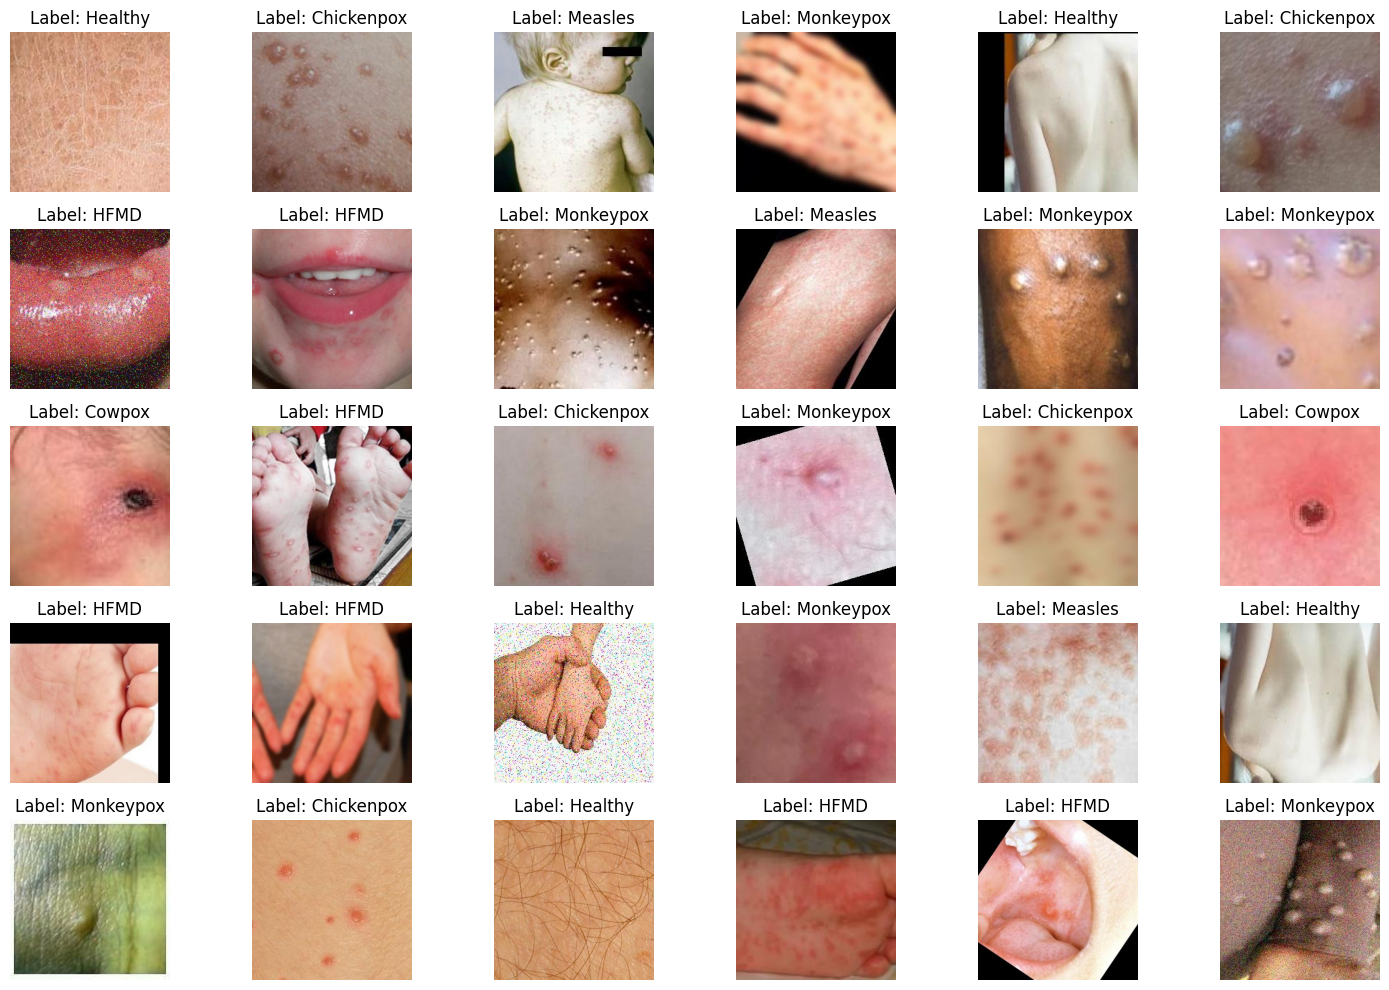

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Path to the main folder containing the subfolder


# Path to the main folder containing the subfolders
main_folder = '/content/drive/MyDrive/kaggle_dataset/mpox_dataset/Augmented Images/Augmented Images/FOLDS_AUG/fold1_AUG/Train'

# List all subfolders (which represent classes)
classes = os.listdir(main_folder)

# Number of images to display
num_images = 30

# Number of rows and columns in the grid
rows = 5
cols = 6

# Create a figure to display the images
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

for i in range(num_images):
    # Randomly select a class
    random_class = random.choice(classes)

    # Path to the selected class folder
    class_folder = os.path.join(main_folder, random_class)

    # List all files in the selected class folder
    images = os.listdir(class_folder)

    # Randomly select an image
    random_image = random.choice(images)

    # Path to the selected image
    image_path = os.path.join(class_folder, random_image)

    # Open and display the image
    image = Image.open(image_path)
    ax = axes[i // cols, i % cols]
    ax.imshow(image)
    ax.set_title(f"Label: {random_class}")
    ax.axis('off')  # Hide axes

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score
import numpy as np

In [ ]:
# Define transformations for train, validation, and test datasets
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Load the datasets
train_dataset = ImageFolder(root='/content/drive/MyDrive/kaggle_dataset/mpox_dataset/Augmented Images/Augmented Images/FOLDS_AUG/fold1_AUG/Train', transform=transform['train'])
val_dataset = ImageFolder(root='/content/drive/MyDrive/kaggle_dataset/mpox_dataset/Original Images/Original Images/FOLDS/fold1/Valid', transform=transform['val'])
test_dataset = ImageFolder(root='/content/drive/MyDrive/kaggle_dataset/mpox_dataset/Original Images/Original Images/FOLDS/fold1/Test', transform=transform['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Load the pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Replace the final fully connected layer to match the number of classes (6 in this case)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)

# Move the model to the appropriate device (GPU/CPU)
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]


NameError: name 'device' is not defined

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_running_corrects = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

        val_acc = val_running_corrects.double() / len(val_loader.dataset)
        print(f"Validation Acc: {val_acc:.4f}")

    return model

# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


In [ ]:
# Testing the trained model on the test dataset
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_acc = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {test_acc:.4f}')


In [ ]:
torch.save(trained_model, '/content/drive/MyDrive/kaggle_dataset/model.pth')

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Correctly define the transform function
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # ResNet usually expects 224x224 input size
    transforms.ToTensor(),           # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet
])

# 2. Load the image
image = Image.open('/content/drive/MyDrive/kaggle_dataset/mopoxchild.jpg')  # Replace with your image path

# 3. Apply the transform
image = transform(image).unsqueeze(0)  # Add batch dimension

# 4. Move the image tensor to the appropriate device
image = image.to(device)

# 5. Set the model to evaluation mode
model.eval()

# 6. Disable gradient calculation (not needed for inference)
with torch.no_grad():
    output = model(image)

# 7. Get the predicted class
_, predicted_class = torch.max(output, 1)

# 8. Map the predicted class index to the actual class name
class_names = ['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox']  # Replace with your actual class names
predicted_class_name = class_names[predicted_class.item()]

print(f'Predicted Class: {predicted_class_name}')


In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.4/447.4 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/

In [ ]:

import gradio as gr
import torch
from torchvision import transforms
from PIL import Image

# Load your trained model
model = torch.load('/content/drive/MyDrive/kaggle_dataset/model.pth',
                    map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

model.eval()  # Set the model to evaluation mode

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet usually expects 224x224 input size
    transforms.ToTensor(),           # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet
])

# Define a function to classify images
def classify_image(image):
    # Apply the transformations
    image = Image.fromarray(image)  # Convert numpy array to PIL Image
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image tensor to the appropriate device
    image = image.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # Disable gradient calculation (not needed for inference)
    with torch.no_grad():
        output = model(image)

    # Get the predicted class
    _, predicted_class = torch.max(output, 1)

    # Map the predicted class index to the actual class name
    class_names = ['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox']  # Replace with your actual class names
    predicted_class_name = class_names[predicted_class.item()]

    return predicted_class_name

# Gradio interface setup
image_input = gr.Image(type="numpy")  # Use type="numpy" to accept numpy arrays
label_output = gr.Label()  # Just use gr.Label for a single output label

# Launch the Gradio interface
gr.Interface(fn=classify_image, inputs=image_input, outputs=label_output).launch()




<ipython-input-13-4d4872294bf8>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/kaggle_dataset/model.pth',


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a9bf4d8c4838a931db.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
